### Importing libraries

In [1]:
import lifelines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from lifelines.fitters import ParametricRegressionFitter
from autograd import numpy as np

In [2]:
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter

In [3]:
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter, PiecewiseExponentialRegressionFitter

In [4]:
telco = pd.read_csv('telco.csv')
telco.head()

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No


#### We see that we have several columns that are not numeric and are categorical, so they require transformations. We need to transform region, marital, ed, retire, gender, voice, internet, forward, custcat and churn columns using encodings.

In [5]:
cols = ['region','marital','ed', 'retire', 'gender', 'voice','internet','forward', 'custcat', 'churn']
 
encoded_1 = pd.get_dummies(telco,
               columns=cols,
               prefix=cols,
               drop_first=False)
 
encoded_1.head()

,ID,tenure,age,address,income,region_Zone 1,region_Zone 2,region_Zone 3,marital_Married,marital_Unmarried,...,internet_No,internet_Yes,forward_No,forward_Yes,custcat_Basic service,custcat_E-service,custcat_Plus service,custcat_Total service,churn_No,churn_Yes
0,1,13,44,9,64,0,1,0,1,0,...,1,0,0,1,1,0,0,0,0,1
1,2,11,33,7,136,0,0,1,1,0,...,1,0,0,1,0,0,0,1,0,1
2,3,68,52,24,116,0,0,1,1,0,...,1,0,1,0,0,0,1,0,1,0
3,4,33,33,12,33,0,1,0,0,1,...,1,0,1,0,1,0,0,0,0,1
4,5,23,30,9,30,0,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0


#### In survival analysis it's common to use drop_first=True to avoid multicollinearity. So, let's build survival model based on that logic.

In [6]:
cols = ['region','marital','ed', 'retire', 'gender', 'voice','internet','forward', 'custcat', 'churn']
 
survival = pd.get_dummies(telco,
               columns=cols,
               prefix=cols,
               drop_first=True)
 
survival.head()

,ID,tenure,age,address,income,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,...,ed_Some college,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service,churn_Yes
0,1,13,44,9,64,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,2,11,33,7,136,0,1,0,0,0,...,0,0,1,1,0,1,0,0,1,1
2,3,68,52,24,116,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,4,33,33,12,33,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
4,5,23,30,9,30,1,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0


In [7]:
survival.columns

Index(['ID', 'tenure', 'age', 'address', 'income', 'region_Zone 2',
       'region_Zone 3', 'marital_Unmarried', 'ed_Did not complete high school',
       'ed_High school degree', 'ed_Post-undergraduate degree',
       'ed_Some college', 'retire_Yes', 'gender_Male', 'voice_Yes',
       'internet_Yes', 'forward_Yes', 'custcat_E-service',
       'custcat_Plus service', 'custcat_Total service', 'churn_Yes'],
      dtype='object')

#### As we see after using drop_first = True, it removes the refernce groups, eliminating 10 columns such as region_Zone 1, marital_Married, and etc.

In [8]:
survival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   ID                               1000 non-null   int64
 1   tenure                           1000 non-null   int64
 2   age                              1000 non-null   int64
 3   address                          1000 non-null   int64
 4   income                           1000 non-null   int64
 5   region_Zone 2                    1000 non-null   uint8
 6   region_Zone 3                    1000 non-null   uint8
 7   marital_Unmarried                1000 non-null   uint8
 8   ed_Did not complete high school  1000 non-null   uint8
 9   ed_High school degree            1000 non-null   uint8
 10  ed_Post-undergraduate degree     1000 non-null   uint8
 11  ed_Some college                  1000 non-null   uint8
 12  retire_Yes                       1000 non-null   

In [9]:
survival["tenure"] = np.where(survival["tenure"] == 0, 0.0001, survival["tenure"])

In [10]:
survival = survival.drop(columns=["ID"])

### Accelerated Failure Time (AFT) Model using all distributions

In [11]:
weib = WeibullFitter()
exp = ExponentialFitter()
lognorm = LogNormalFitter()
loglogist = LogLogisticFitter()

### Weibull distribution

In [12]:
weib_aft = WeibullAFTFitter()
weib_aft.fit(survival, duration_col='tenure', event_col='churn_Yes')
weib_aft_pd = weib_aft.predict_survival_function(survival).transpose()
avg_weib = weib_aft_pd.mean().to_list()
weib_aft_pd

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0
0,0.993953,0.986248,0.977806,0.968879,0.959599,0.950048,0.940288,0.930361,0.920302,0.910139,...,0.430356,0.423541,0.416813,0.410173,0.403620,0.397153,0.390772,0.384477,0.378266,0.372139
1,0.997514,0.994333,0.990831,0.987108,0.983216,0.979188,0.975047,0.970809,0.966487,0.962092,...,0.707480,0.702859,0.698256,0.693669,0.689098,0.684546,0.680010,0.675492,0.670992,0.666510
2,0.999629,0.999154,0.998629,0.998069,0.997481,0.996871,0.996242,0.995596,0.994934,0.994259,...,0.949748,0.948822,0.947893,0.946963,0.946031,0.945097,0.944161,0.943224,0.942285,0.941345
3,0.992808,0.983655,0.973642,0.963071,0.952102,0.940835,0.929342,0.917676,0.905880,0.893986,...,0.366599,0.359699,0.352910,0.346229,0.339655,0.333189,0.326827,0.320570,0.314416,0.308364
4,0.997530,0.994370,0.990891,0.987192,0.983326,0.979324,0.975209,0.970997,0.966703,0.962336,...,0.709087,0.704486,0.699902,0.695334,0.690783,0.686249,0.681732,0.677232,0.672750,0.668285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.990615,0.978702,0.965709,0.952037,0.937897,0.923425,0.908718,0.893846,0.878867,0.863824,...,0.269600,0.262991,0.256526,0.250200,0.244013,0.237963,0.232045,0.226259,0.220602,0.215072
996,0.988005,0.972823,0.956325,0.939030,0.921217,0.903065,0.884697,0.866209,0.847674,0.829150,...,0.186808,0.180968,0.175293,0.169780,0.164426,0.159225,0.154176,0.149273,0.144513,0.139893
997,0.999708,0.999334,0.998920,0.998479,0.998016,0.997536,0.997040,0.996531,0.996009,0.995477,...,0.960218,0.959480,0.958740,0.957999,0.957257,0.956513,0.955767,0.955020,0.954271,0.953521
998,0.998338,0.996209,0.993863,0.991366,0.988753,0.986044,0.983255,0.980397,0.977478,0.974506,...,0.793542,0.790075,0.786613,0.783156,0.779704,0.776258,0.772817,0.769382,0.765953,0.762530


### LogNormal Distribution

In [13]:
lognorm_aft = LogNormalAFTFitter()
lognorm_aft.fit(survival, duration_col='tenure', event_col='churn_Yes')
lognorm_aft_pd = lognorm_aft.predict_survival_function(survival).transpose()
avg_lognorm = lognorm_aft_pd.mean()
lognorm_aft_pd

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0
0,0.998885,0.994322,0.986919,0.977543,0.966829,0.955220,0.943029,0.930480,0.917732,0.904904,...,0.465359,0.460611,0.455943,0.451351,0.446835,0.442392,0.438022,0.433721,0.429490,0.425325
1,0.999731,0.998333,0.995699,0.992004,0.987446,0.982196,0.976392,0.970151,0.963563,0.956704,...,0.624266,0.619722,0.615233,0.610797,0.606413,0.602081,0.597800,0.593570,0.589388,0.585255
2,1.000000,0.999996,0.999985,0.999961,0.999922,0.999865,0.999789,0.999691,0.999573,0.999432,...,0.968395,0.967536,0.966672,0.965803,0.964929,0.964050,0.963166,0.962277,0.961384,0.960487
3,0.997843,0.990049,0.978331,0.964234,0.948737,0.932457,0.915798,0.899022,0.882308,0.865775,...,0.385788,0.381224,0.376747,0.372355,0.368045,0.363815,0.359663,0.355586,0.351584,0.347654
4,0.999874,0.999138,0.997645,0.995445,0.992626,0.989280,0.985487,0.981319,0.976836,0.972089,...,0.696890,0.692702,0.688554,0.684446,0.680377,0.676348,0.672356,0.668403,0.664488,0.660609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.996389,0.984627,0.968031,0.948898,0.928525,0.907666,0.886768,0.866106,0.845845,0.826085,...,0.323425,0.319143,0.314951,0.310847,0.306827,0.302889,0.299031,0.295250,0.291545,0.287913
996,0.990672,0.966092,0.935554,0.903224,0.870926,0.839499,0.809322,0.780550,0.753220,0.727307,...,0.214104,0.210637,0.207255,0.203957,0.200740,0.197599,0.194534,0.191542,0.188620,0.185765
997,1.000000,0.999997,0.999988,0.999969,0.999937,0.999891,0.999828,0.999748,0.999650,0.999533,...,0.972098,0.971324,0.970544,0.969759,0.968969,0.968174,0.967374,0.966569,0.965760,0.964947
998,0.999937,0.999531,0.998654,0.997302,0.995513,0.993333,0.990806,0.987976,0.984881,0.981555,...,0.754915,0.751141,0.747396,0.743679,0.739990,0.736330,0.732697,0.729092,0.725515,0.721965


### LogLogistic Distribution

In [14]:
loglogist_aft = LogLogisticAFTFitter()
loglogist_aft.fit(survival, duration_col='tenure', event_col='churn_Yes')
loglogist_aft_pd = loglogist_aft.predict_survival_function(survival).transpose()
avg_loglogist = loglogist_aft_pd.mean().to_list() 
loglogist_aft_pd

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0
0,0.996235,0.990108,0.982661,0.974264,0.965135,0.955428,0.945258,0.934718,0.923883,0.912817,...,0.441973,0.436533,0.431191,0.425946,0.420797,0.415741,0.410775,0.405899,0.401111,0.396407
1,0.998330,0.995598,0.992251,0.988444,0.984264,0.979771,0.975010,0.970017,0.964820,0.959445,...,0.641526,0.636431,0.631384,0.626386,0.621436,0.616535,0.611683,0.606878,0.602121,0.597412
2,0.999888,0.999705,0.999478,0.999219,0.998933,0.998622,0.998290,0.997938,0.997569,0.997183,...,0.963997,0.963223,0.962445,0.961663,0.960878,0.960089,0.959297,0.958501,0.957703,0.956901
3,0.994829,0.986443,0.976304,0.964938,0.952662,0.939698,0.926217,0.912350,0.898208,0.883878,...,0.365398,0.360292,0.355295,0.350405,0.345619,0.340934,0.336348,0.331858,0.327461,0.323155
4,0.998785,0.996794,0.994351,0.991567,0.988504,0.985203,0.981697,0.978010,0.974161,0.970169,...,0.710997,0.706437,0.701906,0.697406,0.692937,0.688497,0.684089,0.679711,0.675364,0.671048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.993042,0.981811,0.968320,0.953307,0.937224,0.920386,0.903033,0.885348,0.867482,0.849551,...,0.299306,0.294694,0.290194,0.285803,0.281517,0.277333,0.273248,0.269258,0.265361,0.261555
996,0.986698,0.965583,0.940779,0.913876,0.885838,0.857316,0.828773,0.800537,0.772844,0.745860,...,0.181676,0.178415,0.175249,0.172176,0.169190,0.166289,0.163469,0.160728,0.158062,0.155469
997,0.999843,0.999586,0.999269,0.998906,0.998504,0.998069,0.997604,0.997112,0.996595,0.996055,...,0.950243,0.949188,0.948129,0.947065,0.945998,0.944926,0.943851,0.942772,0.941689,0.940602
998,0.999086,0.997588,0.995748,0.993647,0.991333,0.988836,0.986178,0.983378,0.980451,0.977407,...,0.765951,0.761968,0.758001,0.754051,0.750118,0.746203,0.742305,0.738426,0.734565,0.730722


### Exponential Distribution

In [15]:
class ExponentialFitter(ParametricRegressionFitter):

    _fitted_parameter_names = ["lambda_"]

    def _cumulative_hazard(self, params, T, Xs):
        lambda_params = params["lambda_"]
        log_lambda_ = np.exp(Xs["lambda_"] @ lambda_params)
        return T / log_lambda_

exp_aft_fitter = ExponentialFitter()
exp_aft_fitter.fit(survival, duration_col='tenure', event_col='churn_Yes')
exp_aft_survival = exp_aft_fitter.predict_survival_function(survival).transpose()
avg_exp_aft = exp_aft_survival.mean().to_list()  
exp_aft_survival

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0
0,0.987412,0.974983,0.962710,0.950592,0.938626,0.926811,0.915144,0.903625,0.892250,0.881019,...,0.450200,0.444533,0.438938,0.433412,0.427957,0.422570,0.417251,0.411998,0.406812,0.401691
1,0.993358,0.986759,0.980205,0.973694,0.967226,0.960801,0.954419,0.948079,0.941782,0.935526,...,0.657131,0.652766,0.648430,0.644122,0.639844,0.635594,0.631372,0.627178,0.623012,0.618874
2,0.999400,0.998800,0.998200,0.997601,0.997002,0.996403,0.995805,0.995207,0.994609,0.994012,...,0.962869,0.962291,0.961714,0.961136,0.960559,0.959982,0.959406,0.958830,0.958254,0.957679
3,0.979795,0.959997,0.940600,0.921595,0.902974,0.884729,0.866852,0.849337,0.832176,0.815362,...,0.276380,0.270795,0.265324,0.259963,0.254710,0.249564,0.244521,0.239581,0.234740,0.229997
4,0.995042,0.990108,0.985199,0.980314,0.975454,0.970617,0.965805,0.961016,0.956251,0.951510,...,0.731145,0.727520,0.723913,0.720324,0.716752,0.713198,0.709662,0.706144,0.702642,0.699159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.986564,0.973309,0.960231,0.947330,0.934602,0.922044,0.909656,0.897434,0.885376,0.873480,...,0.426476,0.420746,0.415093,0.409516,0.404013,0.398585,0.393230,0.387946,0.382734,0.377592
996,0.962820,0.927022,0.892555,0.859370,0.827418,0.796655,0.767035,0.738517,0.711059,0.684621,...,0.091905,0.088488,0.085198,0.082030,0.078980,0.076044,0.073216,0.070494,0.067873,0.065350
997,0.998763,0.997528,0.996294,0.995062,0.993831,0.992602,0.991375,0.990149,0.988924,0.987701,...,0.924998,0.923854,0.922711,0.921570,0.920430,0.919292,0.918155,0.917019,0.915885,0.914752
998,0.998228,0.996459,0.994693,0.992930,0.991170,0.989413,0.987660,0.985909,0.984162,0.982418,...,0.894264,0.892680,0.891098,0.889518,0.887942,0.886368,0.884797,0.883229,0.881664,0.880101


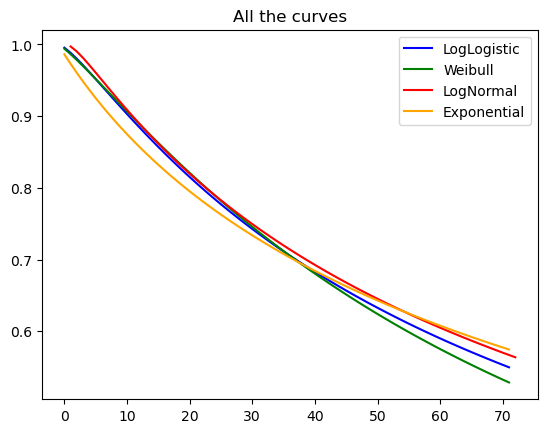

In [16]:
plt.plot(avg_loglogist, color = 'blue', label = 'LogLogistic')
plt.plot(avg_weib, color = "green", label = "Weibull")
plt.plot(avg_lognorm, color = "red", label = "LogNormal")
plt.plot(avg_exp_aft, color = "orange", label = "Exponential")
plt.legend()
plt.title("All the curves")
plt.show()

In [17]:
for model in [weib, exp, lognorm, loglogist]:
    model.fit(durations = survival["tenure"], event_observed = survival["churn_Yes"])
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 3216.8611706815464
The AIC value for ExponentialFitter is 3215.9608134637247
The AIC value for LogNormalFitter is 3209.0351474316735
The AIC value for LogLogisticFitter is 3214.4154757933375


#### AIC values help us decide how well models fit (goodness of fit) our data. The rule is straightforward: lower AIC is better.
#### The WeibullFitter model got an AIC of 3216.86, which is the highest compared to other distributions.
#### The ExponentialFitter model has AIC of 3215.96. This means the exponential distribution might be a bit better at describing the data than the Weibull distribution.
#### The LogLogisticFitter model got an AIC of 3214.42. This means the exponential distribution might be a bit better at describing the data than the Exponential distribution.
#### The LogNormalFitter model has the lowest AIC, just 3209.04. So, it seems like the log-normal distribution fits our data the best among these models.

In [18]:
lognorm_aft.summary.round(decimals=2)

coef  exp(coef)  se(coef)  \
param  covariate                                                    
mu_    address                          0.04       1.04      0.01   
       age                              0.03       1.03      0.01   
       custcat_E-service                1.07       2.90      0.17   
       custcat_Plus service             0.92       2.52      0.22   
       custcat_Total service            1.20       3.32      0.25   
       ed_Did not complete high school  0.37       1.45      0.20   
       ed_High school degree            0.32       1.37      0.16   
       ed_Post-undergraduate degree    -0.03       0.97      0.22   
       ed_Some college                  0.27       1.31      0.17   
       forward_Yes                     -0.20       0.82      0.18   
       gender_Male                      0.05       1.05      0.11   
       income                           0.00       1.00      0.00   
       internet_Yes                    -0.77       0.46      0.14   
       marital_Unmarried               -0.46       0.63      0.12   
       region_Zone 2                   -0.10       0.91      0.14   
       region_Zone 3                    0.05       1.05      0.14   
       retire_Yes                       0.02       1.02      0.44   
       voice_Yes                       -0.43       0.65      0.17   
       Intercept                        2.36      10.61      0.29   
sigma_ Intercept                        0.28       1.32      0.05   

                                        coef lower 95%  coef upper 95%  \
param  covariate                                                         
mu_    address                                    0.03            0.06   
       age                                        0.02            0.05   
       custcat_E-service                          0.73            1.40   
       custcat_Plus service                       0.50            1.35   
       custcat_Total service                      0.71            1.69   
       ed_Did not complete high school           -0.02            0.77   
       ed_High school degree                     -0.00            0.64   
       ed_Post-undergraduate degree              -0.47            0.40   
       ed_Some college                           -0.05            0.60   
       forward_Yes                               -0.55            0.15   
       gender_Male                               -0.17            0.28   
       income                                    -0.00            0.00   
       internet_Yes                              -1.05           -0.49   
       marital_Unmarried                         -0.68           -0.23   
       region_Zone 2                             -0.38            0.18   
       region_Zone 3                             -0.23            0.33   
       retire_Yes                                -0.85            0.89   
       voice_Yes                                 -0.76           -0.10   
       Intercept                                  1.79            2.94   
sigma_ Intercept                                  0.19            0.37   

                                        exp(coef) lower 95%  \
param  covariate                                              
mu_    address                                         1.03   
       age                                             1.02   
       custcat_E-service                               2.08   
       custcat_Plus service                            1.65   
       custcat_Total service                           2.03   
       ed_Did not complete high school                 0.98   
       ed_High school degree                           1.00   
       ed_Post-undergraduate degree                    0.62   
       ed_Some college                                 0.95   
       forward_Yes                                     0.58   
       gender_Male                                     0.84   
       income                                          1.00   
       int

In [19]:
lognorm_aft.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_Yes'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1457.01
         time fit was run = 2023-11-27 20:56:04 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                               
mu_    address                           0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                               0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service                 1.07       2.90       0.17             0.73             1.40                 2.08                 4.06
       custcat_Plus service              0.92       2.52       0.22             0.50             1.35                 1.65                 3.85
       custcat_Total service             1.20       3.32       0.25             0.71             1.69                 2.03                 5.42
       ed_Did not complete high school   0.37       1.45       0.20            -0.02             0.77                 0.98                 2.16
       ed_High school degree             0.32       1.37       0.16            -0.00             0.64                 1.00                 1.89
       ed_Post-undergraduate degree     -0.03       0.97       0.22            -0.47             0.40                 0.62                 1.50
       ed_Some college                   0.27       1.31       0.17            -0.05             0.60                 0.95                 1.82
       forward_Yes                      -0.20       0.82       0.18            -0.55             0.15                 0.58                 1.17
       gender_Male                       0.05       1.05       0.11            -0.17             0.28                 0.84                 1.32
       income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       internet_Yes                     -0.77       0.46       0.14            -1.05            -0.49                 0.35                 0.61
       marital_Unmarried                -0.46       0.63       0.12            -0.68            -0.23                 0.51                 0.80
       region_Zone 2                    -0.10       0.91       0.14            -0.38             0.18                 0.69                 1.20
       region_Zone 3                     0.05       1.05       0.14            -0.23             0.33                 0.80                 1.38
       retire_Yes                        0.02       1.02       0.44            -0.85             0.89                 0.43                 2.44
       voice_Yes                        -0.43       0.65       0.17            -0.76            -0.10                 0.47                 0.90
       Intercept                         2.36      10.61       0.29             1.79             2.94                 5.98                18.84
sigma_ Intercept                         0.28       1.32       0.05             0.19             0.37                 1.20                 1.44

                                         cmp to     z      p   -log2(p)
param  covariate                                                       
mu_    address                             0.00  4.78 <0.005      19.11
       age                                 0.00  4.50 <0.005      17.19
       custcat_E-service                   0.00  6.25 <0.005      31.21
       custcat_Plus service                0.00  4.29 <0.005      15.75
       custcat_Total service               0.00  4.79 <0.005  

### Keeping only the significant features

In [20]:
coefficients = lognorm_aft.summary['coef']
p_values = lognorm_aft.summary['p']
significance_level = 0.05

# Identify significant features and extract column names without prefixes
significant_feature_names = [feature[1] for feature, p_value in zip(coefficients.index, p_values) if p_value < significance_level and feature[1] != 'Intercept']

# Keep only significant features in the original DataFrame
significant_data = survival[significant_feature_names]

### Calculating CLV

In [21]:
MM = 1300
sequence = range(1,len(lognorm_aft_pd.columns)+1)
r = 0.1

for num in sequence:
    lognorm_aft_pd.loc[:,num] = lognorm_aft_pd.loc[:,num]/((1+r/12)**(sequence[num-1]-1))

In [22]:
lognorm_aft_pd["CLV"] = MM * lognorm_aft_pd.sum(axis = 1)
lognorm_aft_pd

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,CLV
0,0.998885,0.986104,0.970674,0.953506,0.935261,0.916395,0.897223,0.877967,0.858782,0.839780,...,0.273071,0.268069,0.263176,0.258389,0.253706,0.249124,0.244639,0.240250,0.235954,48927.236074
1,0.999731,0.990083,0.979309,0.967612,0.955206,0.942274,0.928966,0.915399,0.901669,0.887852,...,0.367398,0.361722,0.356146,0.350668,0.345286,0.339997,0.334801,0.329695,0.324678,56796.304474
2,1.000000,0.991732,0.983524,0.975373,0.967274,0.959225,0.951225,0.943272,0.935366,0.927505,...,0.573598,0.568349,0.563145,0.557986,0.552870,0.547798,0.542770,0.537784,0.532842,69887.191289
3,0.997843,0.981866,0.962227,0.940525,0.917760,0.894558,0.871314,0.848284,0.825633,0.803466,...,0.226006,0.221506,0.217115,0.212828,0.208643,0.204557,0.200568,0.196671,0.192865,44424.629625
4,0.999874,0.990880,0.981223,0.970968,0.960217,0.949071,0.937619,0.925937,0.914089,0.902130,...,0.410664,0.404831,0.399090,0.393439,0.387877,0.382401,0.377011,0.371705,0.366481,59985.542819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.996389,0.976490,0.952096,0.925565,0.898209,0.870774,0.843695,0.817226,0.791513,0.766633,...,0.189202,0.185174,0.181250,0.177428,0.173703,0.170073,0.166535,0.163086,0.159723,40553.427750
996,0.990672,0.958108,0.920155,0.881014,0.842490,0.805377,0.770011,0.736499,0.704837,0.674965,...,0.124875,0.121855,0.118924,0.116081,0.113321,0.110641,0.108039,0.105511,0.103056,32759.931035
997,1.000000,0.991733,0.983528,0.975381,0.967289,0.959251,0.951263,0.943326,0.935438,0.927598,...,0.575843,0.570626,0.565452,0.560322,0.555235,0.550191,0.545191,0.540232,0.535316,69995.744052
998,0.999937,0.991270,0.982215,0.972780,0.963010,0.952959,0.942679,0.932218,0.921617,0.910915,...,0.445309,0.439427,0.433628,0.427911,0.422276,0.416720,0.411242,0.405843,0.400519,62371.121529


In [23]:
telco["CLV"] = lognorm_aft_pd.CLV

### Using kdeplot for visualizations

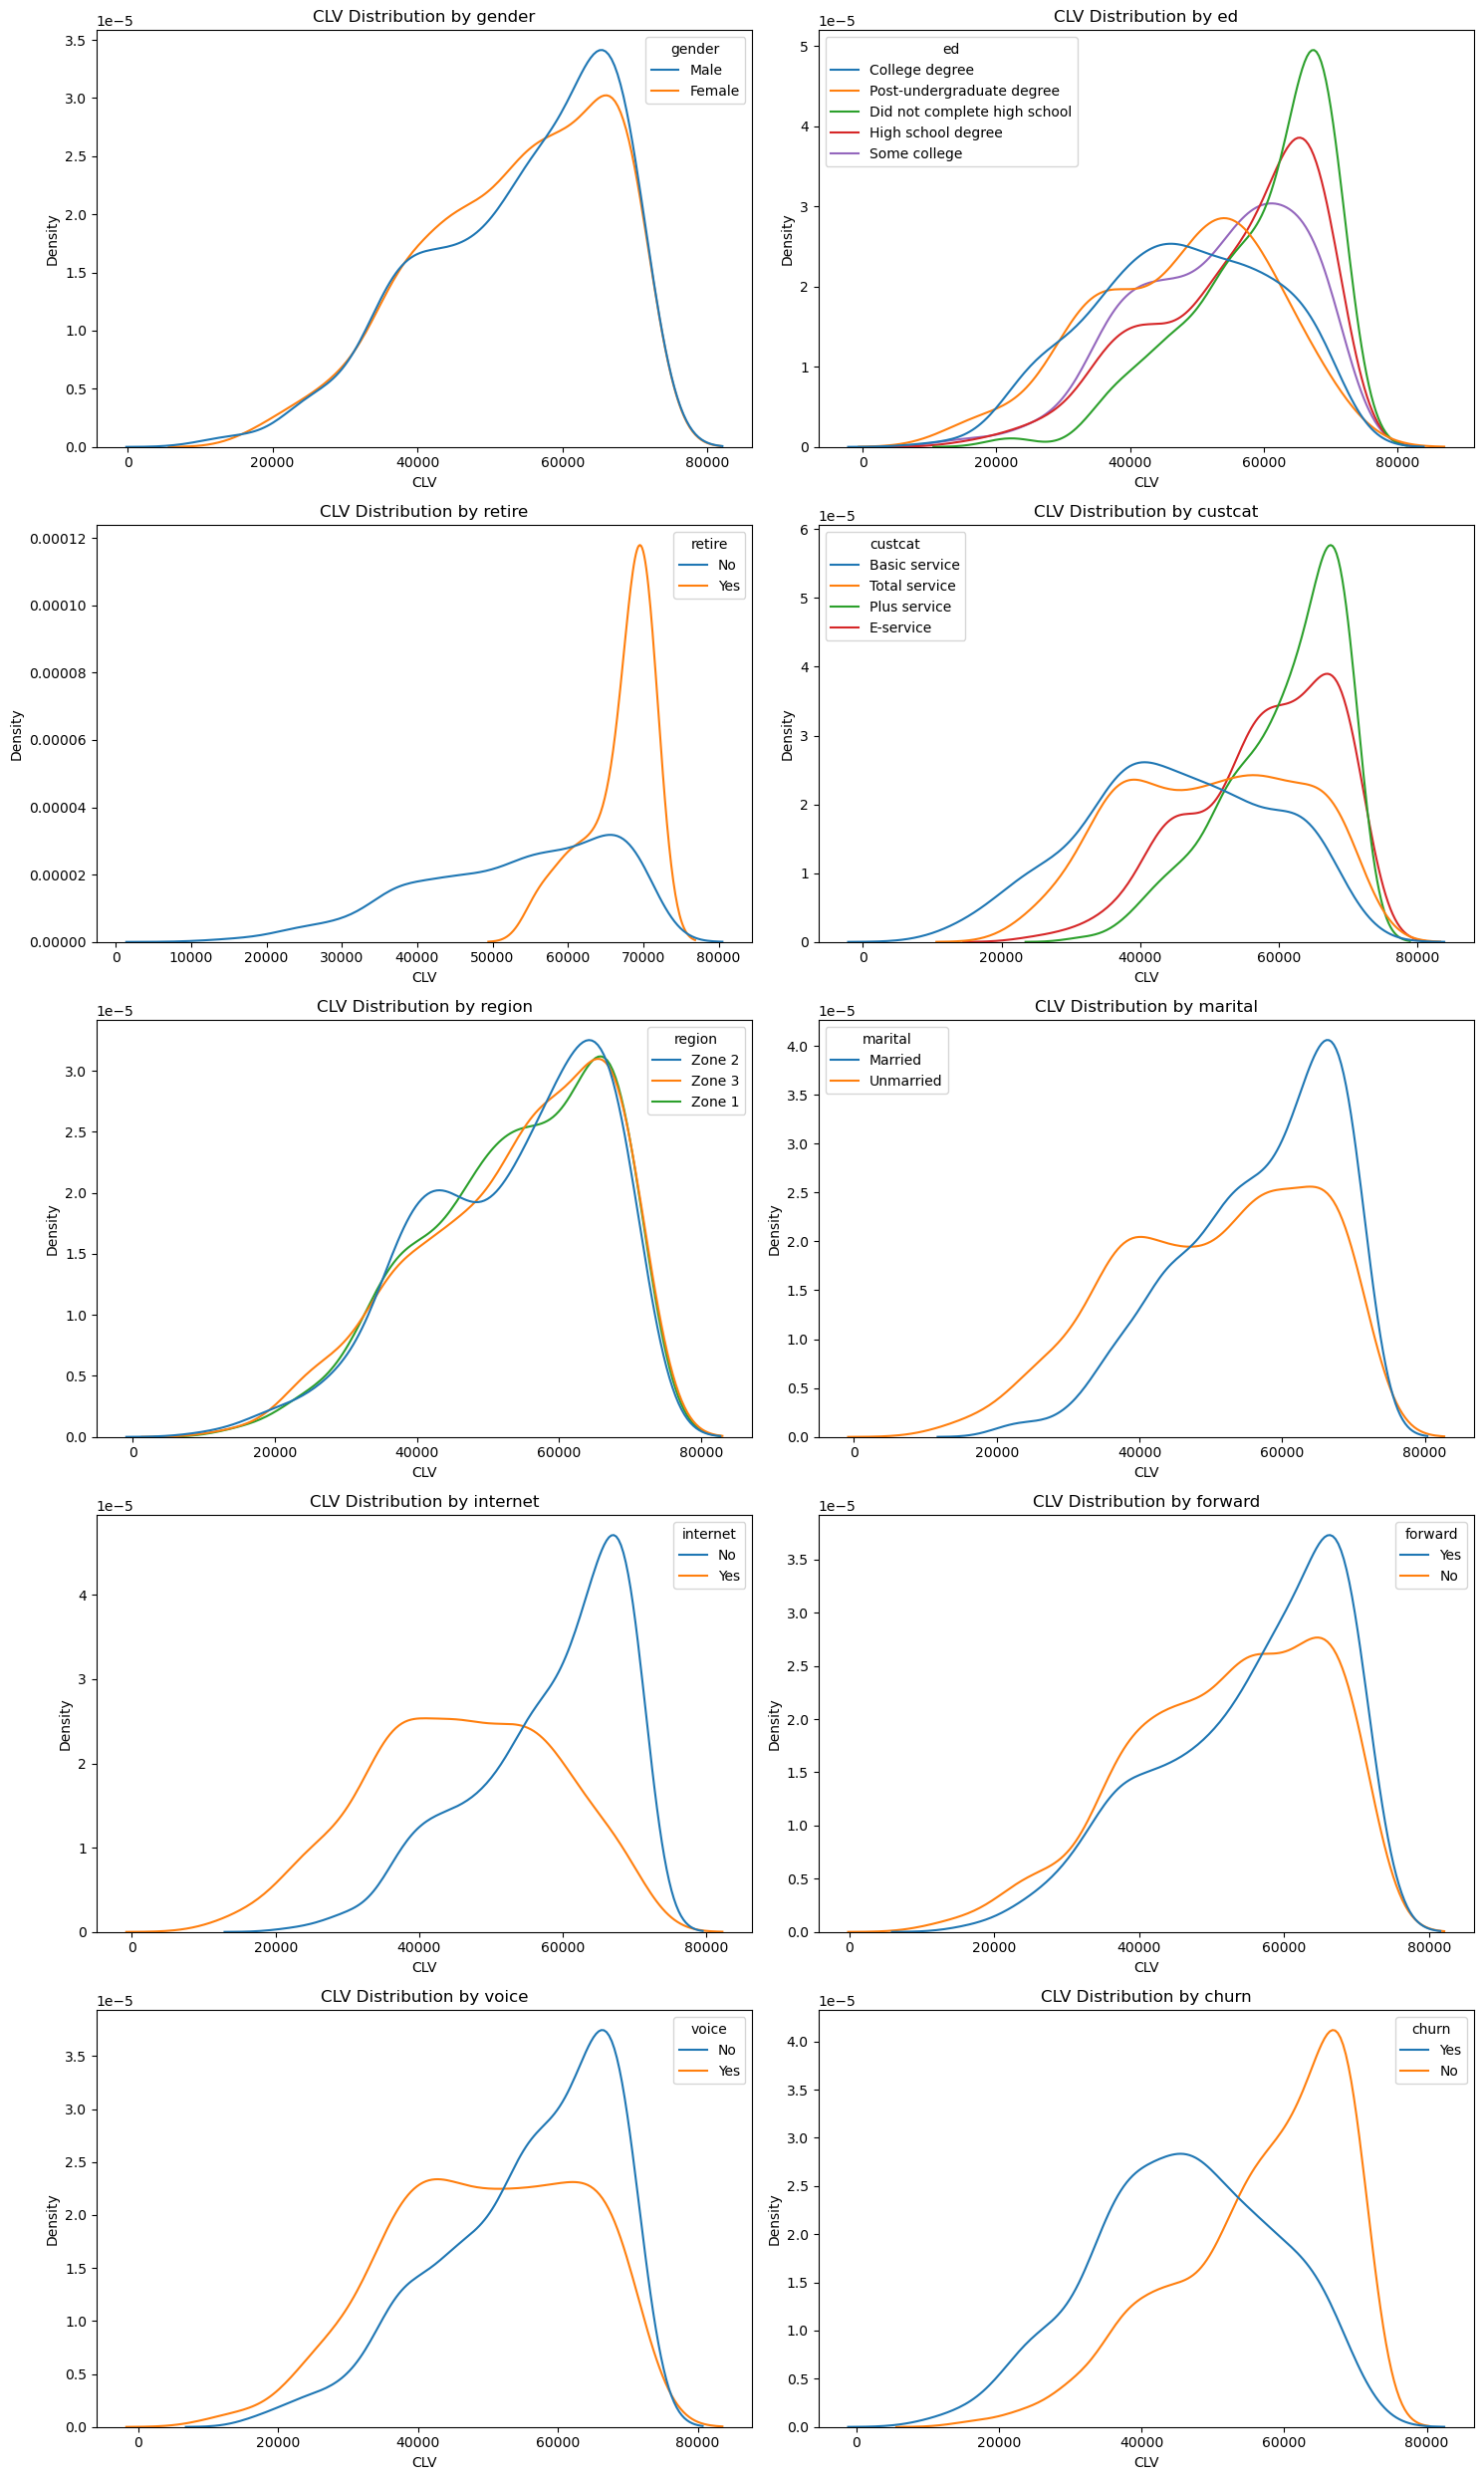

In [24]:
categorical_columns = ['gender', 'ed', 'retire', 'custcat', 'region', 'marital', 'internet', 'forward', 'voice', 'churn']

num_cols = 2  
num_rows = (len(categorical_columns) - 1) // num_cols + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    sns.kdeplot(data=telco, x='CLV', hue=column, ax=axes[i], common_norm=False)
    axes[i].set_title(f'CLV Distribution by {column}')

plt.tight_layout()
plt.show()

### Using displot for visualizations

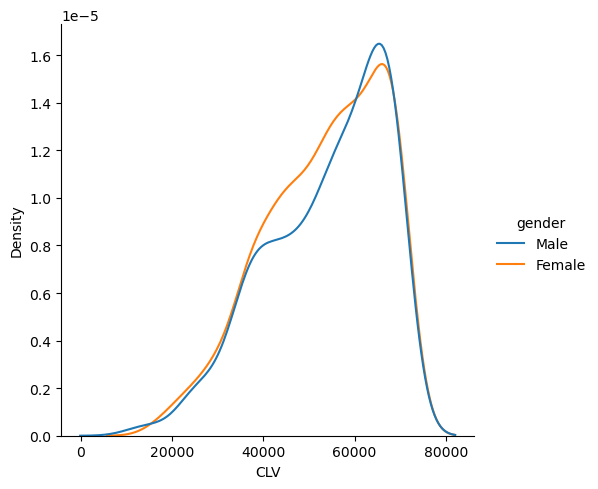

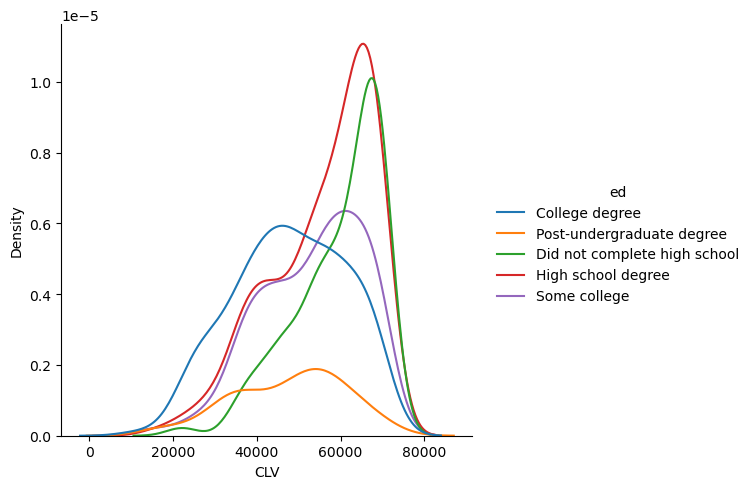

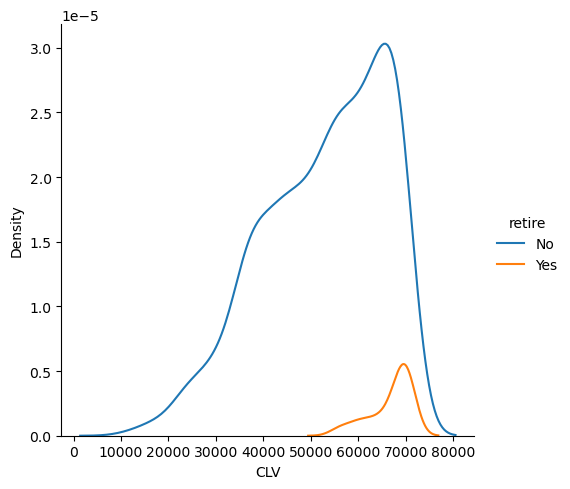

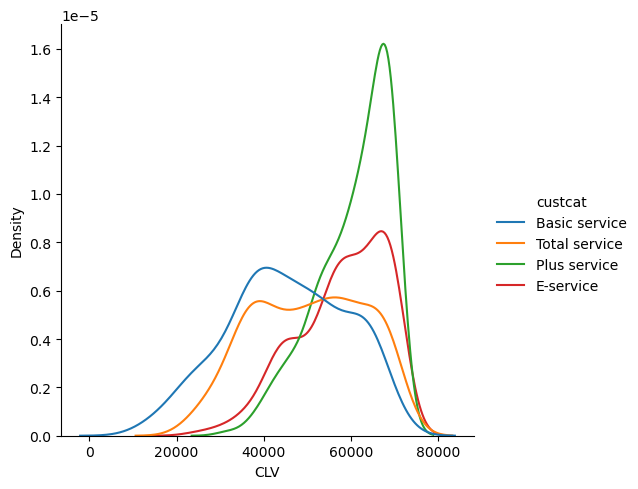

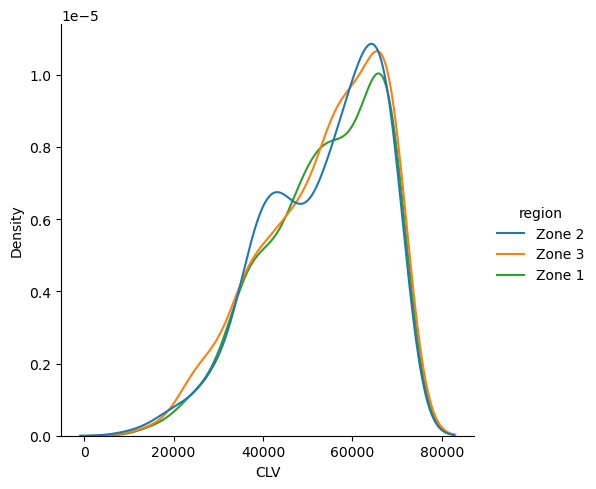

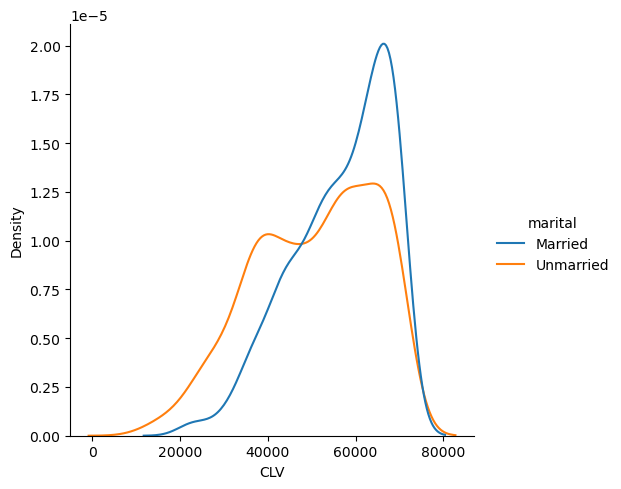

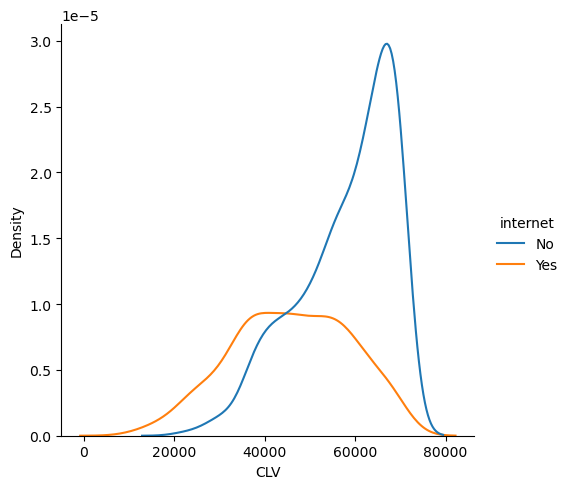

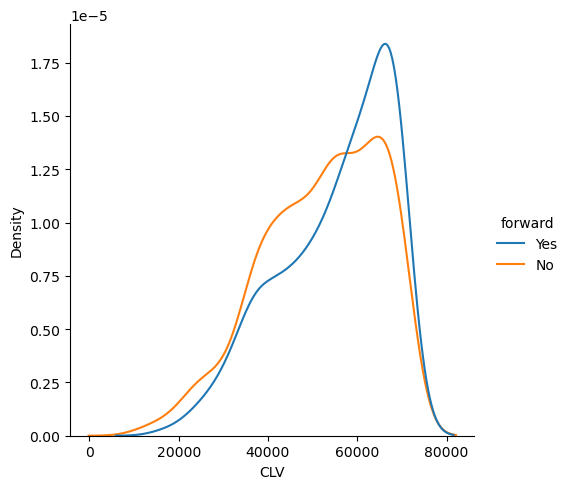

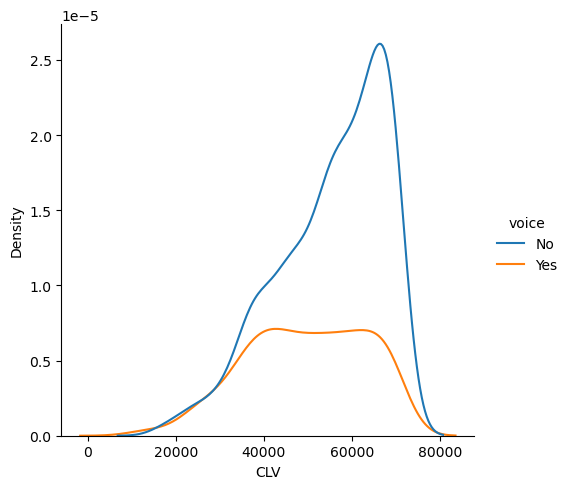

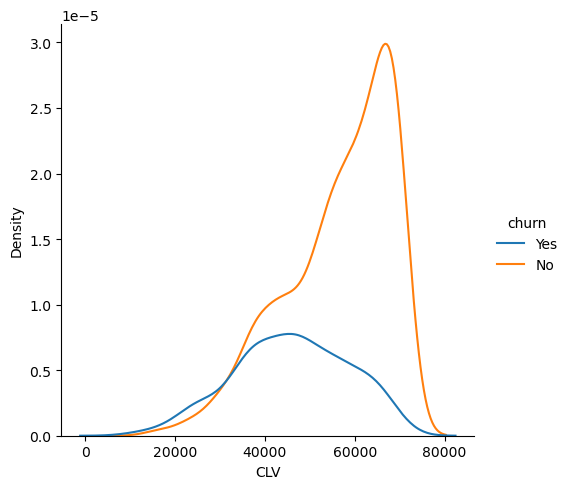

In [25]:
categorical_columns = ['gender', 'ed', 'retire', 'custcat', 'region', 'marital', 'internet', 'forward', 'voice', 'churn']

for col in categorical_columns:
    sns.displot(data=telco, kind='kde', x='CLV', hue=col)


### Calculating Mean CLVs for different groups

In [26]:
categorical_columns = ['gender', 'ed', 'retire', 'custcat', 'region', 'marital', 'internet', 'forward', 'voice', 'churn']

for column in categorical_columns:
    print("\n" + "="*30 + f" Mean CLV by {column} " + "="*30 + "\n")
    print(telco.groupby(column)[["CLV"]].mean())


============================== Mean CLV by gender ==============================

                 CLV
gender              
Female  53314.840532
Male    53845.522616

============================== Mean CLV by ed ==============================

                                       CLV
ed                                        
College degree                47827.964363
Did not complete high school  59541.900231
High school degree            55641.584042
Post-undergraduate degree     47656.406026
Some college                  53198.139965

============================== Mean CLV by retire ==============================

                 CLV
retire              
No      52915.885017
Yes     66857.905470

============================== Mean CLV by custcat ==============================

                        CLV
custcat                    
Basic service  45325.724419
E-service      57923.301359
Plus service   60762.693634
Total service  50300.186344

============================== Me

## Report and Conclusions

### Interpretating coefficients: 
- Gender: The average customer lifetime value is comparable between genders, with a slightly higher CLV for males.
- Education: Customers who did not complete high school exhibit the highest CLV, suggesting potential opportunities for targeted marketing or retention strategies.
- Retire: Retired customers show a significantly higher average CLV, indicating potential loyalty or increased spending among this demographic.
- Custcat: E-service customers demonstrate the highest CLV, highlighting the importance of digital services in customer value generation.
- Region: Minimal variation in CLV across different regions suggests a consistent customer value regardless of geographic location.
- Marital: Married customers have a higher CLV, indicating potential higher spending or loyalty in this segment.
- Internet: Customers without internet service surprisingly show higher CLV, possibly due to other factors influencing spending habits.
- Forward: Forwarding services have a marginal impact on CLV, with a slight increase observed for customers using this feature.
- Voice: Customers without voice service exhibit a higher CLV, indicating that voice services may not significantly contribute to customer value.
- Churn: Non-churning customers have a notably higher CLV, emphasizing the financial impact of customer retention strategies.

### Most valuable segments and definition of valuable customers:
- The most valuable segments can be characterized by higher Customer Lifetime Value (CLV). In this context, "valuable" refers to customer groups that contribute more revenue over their lifetime engagement with the business. 
- Specifically, the segments with higher average CLV, such as retired customers, those without high school education, and Plus service customers, are considered the most valuable. Additionally, non-churning customers, married individuals, and those without internet or voice services are identified as valuable segments. These insights guide strategic efforts towards customer retention, targeted marketing, and service enhancements for optimal business profitability.

### Estimating Annual retention budget

In [27]:
# Calculating Churn Rate
churn_rate = sum(survival['churn_Yes']) / len(survival['churn_Yes'])

# Calculating Retention Rate
retention_rate = 1 - churn_rate

# Calculating Average CLV
average_clv = telco['CLV'].mean()

# Calculating Annual Retention Budget
total_customers = len(survival)
annual_retention_budget = total_customers * retention_rate * average_clv

print(f"Churn Rate: {churn_rate:.2%}")
print(f"Retention Rate: {retention_rate:.2%}")
print(f"Average CLV: {average_clv:.2f}֏")
print(f"Annual Retention Budget: {annual_retention_budget:.2f}֏")

Churn Rate: 27.40%
Retention Rate: 72.60%
Average CLV: 53571.16֏
Annual Retention Budget: 38892662.14֏


### Retention Suggestions
#### 1. Targeted Engagement for Voice Service Users:
- Customers without voice service exhibit a higher CLV. Develop targeted communication strategies or exclusive offers for this segment to strengthen their loyalty and engagement.

#### 2. Improving Internet Service Experience:
- Despite higher CLV for customers without internet service, explore ways to enhance the internet service experience. Identify factors contributing to CLV in this segment and work on improving overall customer satisfaction.

#### 3. Promotion of Forwarding Services:
- While forwarding services have a marginal impact on CLV, consider promotional campaigns or incentives to encourage the usage of forwarding services. This can lead to increased engagement and potentially higher CLV.

#### 4. Retention Efforts for Married Customers:
- Married customers have a higher CLV. Implement targeted retention efforts such as personalized offers, loyalty programs, or exclusive services to strengthen the loyalty of this valuable customer segment.